In [1]:
import pandas as pd
import pts2txt as pts
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import roberts, sobel, scharr, prewitt, gabor_kernel, gabor
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from scipy import misc
from scipy import ndimage as nd
from PIL import Image
from pathlib import Path
import math
import itertools
# pip3 install opencv-python # if missing cv2

# About SCUT-FBP5500 Dataset
https://github.com/HCIILAB/SCUT-FBP5500-Database-Release

All the images are labeled with beauty scores ranging from [1, 5] by totally 60 volunteers, and 86 facial landmarks are also located to the significant facial components of each images. Specifically, we save the facial landmarks in ‘pts’ format, which can be converted to 'txt' format by running pts2txt.py.

### PTS Format

PTS format is a facial landmark data file. The pts file extension is mainly related to a special text based format that contains 3D data in so-called PointCloud. PointCloud is basically a 3D coordinate system, in which points are usually defined by X, Y, and Z coordinates. Used to describe external surface of an object.

If we want to rebuild facial landmarks ourselves we could use this resource:

Resources:
https://github.com/songhengyang/face_landmark_factory

https://towardsdatascience.com/facial-mapping-landmarks-with-dlib-python-160abcf7d672


## Note: I am still unclear on how to integrate these image segmentation labels

In [2]:
# navigate to directory for processing pts files
#os.chdir("./data/SCUT-FBP5500_v2")

In [3]:
# check current directory
#os.getcwd()

In [4]:
# run pts2txt main function (convert pts to txt)
# note this script doesn't quit
#pts.main() 

## The above cells converted pts files to txt with 86 facial landmarks (lines) and tripled the file size

We need to evaluate the facial landmarks statistically for feature extraction.
I would like to build a left side versus right side symmetry score as well as height and width ratio of shape, nose, mouth. Each of the 86 points corresponds to a specific landmark location. So once we can subset the points we can arrive at these features.

https://towardsdatascience.com/recommender-system-bayesian-personalized-ranking-from-implicit-feedback-78684bfcddf6

# Reviewing Facial Landmarks

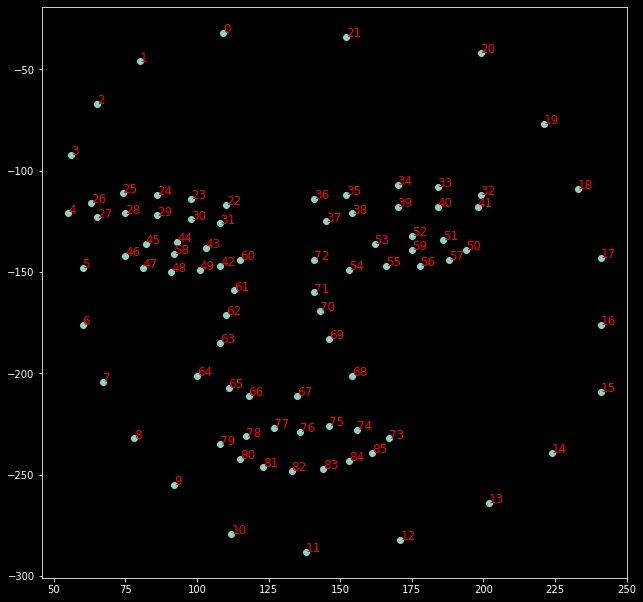

In [74]:
with open("data/SCUT-FBP5500_v2/landmark_txt/AF2.txt",'r') as f:
    lines = f.readlines()
    points = [l.split() for l in lines]
    p_float = [(float(c[0]),float(c[1])) for c in points]
    
# please note that I used negative to flip the image upright
xs = [c[0] for c in p_float]
ys = [-c[1] for c in p_float]
plt.plot(xs, ys, "o")
for i, c in enumerate(p_float):
    plt.text(int(c[0]), int(-c[1]), str(i), color="red", fontsize=12)

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10.5, 10.5, forward=True)

In [144]:
shape = p_float[0:21]
brows = p_float[22:41]
r_brow = p_float[22:31]
l_brow = p_float[32:41]
eyes = p_float[42:59]
r_eye = p_float[42:49]
l_eye = p_float[50:57]
r_pupil = p_float[58]
l_pupil = p_float[59]
nose = p_float[60:72]
mouth = p_float[73:85]

# Testing the Segmentation

In [96]:
# helper function to visualize facial landmark
def draw_rect(image, box):
    """
    image = cv2.imread()
    box = 4 coordinate point []
    """
    y_min = int(max(1, (box[0] * image.height)))
    x_min = int(max(1, (box[1] * image.width)))
    y_max = int(min(image.height, (box[2] * image.height)))
    x_max = int(min(image.width, (box[3] * image.width)))
    
    # draw a rectangle on the image
    cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (255, 255, 255), 2)

In [156]:
img = cv2.imread(r"data/SCUT-FBP5500_v2/Images/AF1.jpg")
with open("data/SCUT-FBP5500_v2/landmark_txt/AF1.txt",'r') as f:
    lines = f.readlines()
    points = [l.split() for l in lines]
    p_float = [[int(float(c[0])),int(float(c[1]))] for c in points]
shape = p_float[0:21]
brows = p_float[22:41]
r_brow = p_float[22:31]
l_brow = p_float[32:41]
eyes = p_float[42:59]
r_eye = p_float[42:49]
l_eye = p_float[50:57]
r_pupil = p_float[58]
l_pupil = p_float[59]
nose = p_float[60:72]
mouth = p_float[73:85]


In [ ]:
# this was for checking mapping 1 by 1
# brows ok c[0] = y , c[1] = x ; (x_min-10, y_min-5), (x_max+10, y_max+5)
# eyes not ok (x_min-10, y_min-10), (x_max+5, y_max+10)
# nose (x_min-2, y_min), (x_max+2, y_max)
# mouth (x_min-10, y_min-10), (x_max+5, y_max+10)
xs = [int(c[0]) for c in shape]
ys = [int(c[1]) for c in shape]
x_min = min(xs)
y_min = min(ys)
x_max = max(xs)
y_max = max(ys)
cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (255, 255, 255), 1)
cv2.imshow("image", img)
cv2.waitKey(0)

In [19]:
shapes = [shape, brows, eyes, nose, mouth]

# this is for a composite map 
for s in shapes:
    ys = [int(c[0]) for c in s]
    xs = [int(c[1]) for c in s]
    x_min = min(xs)
    y_min = min(ys)
    x_max = max(ys)
    y_max = max(xs)
    cv2.rectangle(img, (x_min-10, y_min-5), (x_max+10, y_max+5), (255, 255, 255), 1)
cv2.imshow("image", img)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Masking - Abandoned 

In [159]:
# this will create a shape so that we can analyze area of face
poly2 = cv2.fillConvexPoly(img, np.array(shape), color = 255)
cv2.imshow('Original',poly2)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [125]:
# this is an abandoned masking step
mask = np.zeros(img.shape[0:2], dtype=np.uint8)
cv2.drawContours(mask,shape, -1, (255, 255, 255), -1, cv2.LINE_AA)
res = cv2.bitwise_and(img,img,mask = mask)
rect = cv2.boundingRect(points) # returns (x,y,w,h) of the rect
cropped = res[rect[1]: rect[1] + rect[3], rect[0]: rect[0] + rect[2]]
## crate the white background of the same size of original image
wbg = np.ones_like(img, np.uint8)*255
cv2.bitwise_not(wbg,wbg, mask=mask)
# overlap the resulted cropped image on the white background
dst = wbg+res
cv2.imshow('Original',img)
cv2.imshow("Mask",mask)
cv2.imshow("Cropped", cropped )
cv2.imshow("Samed Size Black Image", res)
cv2.imshow("Samed Size White Image", dst)
cv2.waitKey(0)
cv2.destroyAllWindows()

error: OpenCV(4.5.3) /private/var/folders/24/8k48jl6d249_n_qfxwsl6xvm0000gn/T/pip-req-build-vy_omupv/opencv/modules/imgproc/src/drawing.cpp:2501: error: (-215:Assertion failed) npoints > 0 in function 'drawContours'


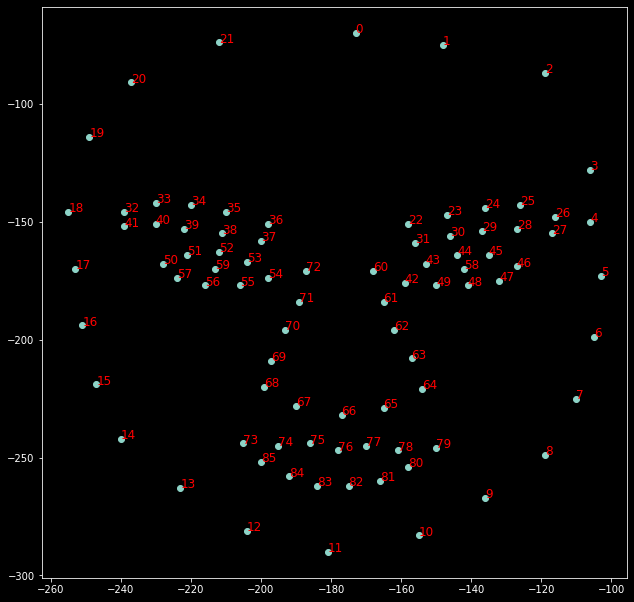

In [85]:
# repeat for asian male
with open("data/SCUT-FBP5500_v2/landmark_txt/AM1.txt",'r') as f:
    lines = f.readlines()
    points = [l.split() for l in lines]
    p_float = [(float(c[0]),float(c[1])) for c in points]

# please note that I used negative to flip the image upright
xs = [-c[0] for c in p_float]
ys = [-c[1] for c in p_float]
plt.plot(xs, ys, "o")
for i, c in enumerate(p_float):
    plt.text(int(-c[0]), int(-c[1]), str(i), color="red", fontsize=12)

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10.5, 10.5, forward=True)


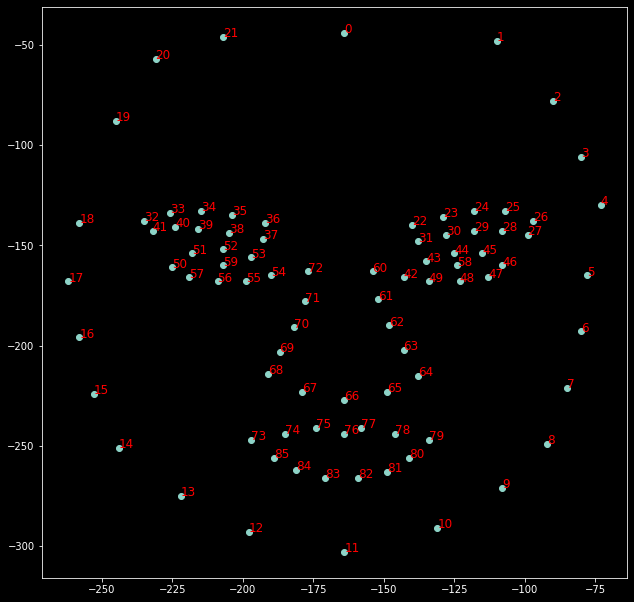

In [86]:
# repeat for caucasian male
with open("data/SCUT-FBP5500_v2/landmark_txt/CM1.txt",'r') as f:
    lines = f.readlines()
    points = [l.split() for l in lines]
    p_float = [(float(c[0]),float(c[1])) for c in points]

# please note that I used negative to flip the image upright
xs = [-c[0] for c in p_float]
ys = [-c[1] for c in p_float]
plt.plot(xs, ys, "o")
for i, c in enumerate(p_float):
    plt.text(int(-c[0]), int(-c[1]), str(i), color="red", fontsize=12)

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10.5, 10.5, forward=True)

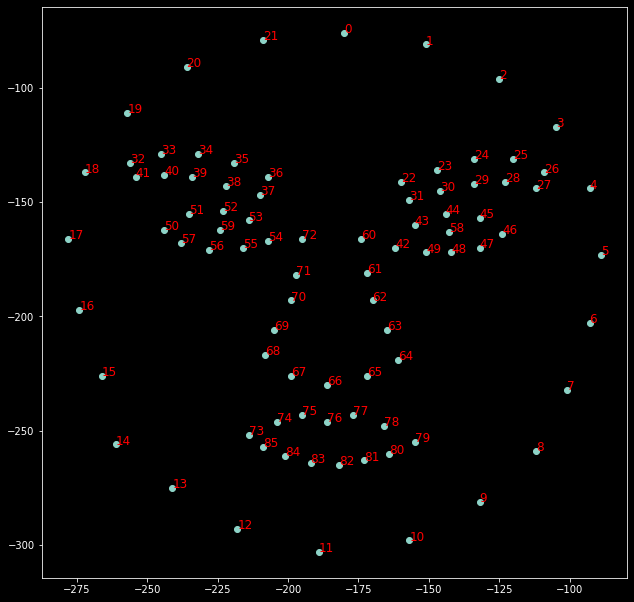

In [87]:
# repeat for caucasian male
with open("data/SCUT-FBP5500_v2/landmark_txt/CF1.txt",'r') as f:
    lines = f.readlines()
    points = [l.split() for l in lines]
    p_float = [(float(c[0]),float(c[1])) for c in points]

# please note that I used negative to flip the image upright
xs = [-c[0] for c in p_float]
ys = [-c[1] for c in p_float]
plt.plot(xs, ys, "o")
for i, c in enumerate(p_float):
    plt.text(int(-c[0]), int(-c[1]), str(i), color="red", fontsize=12)

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10.5, 10.5, forward=True)

# Data Augumentation

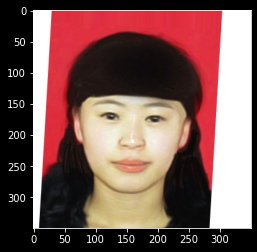

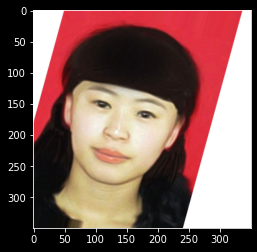

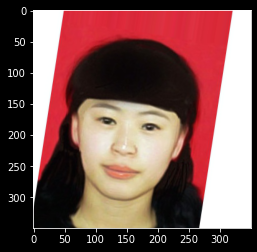

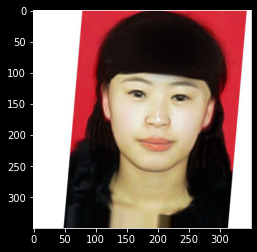

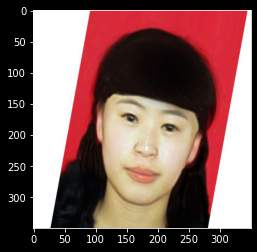

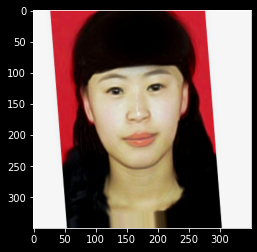

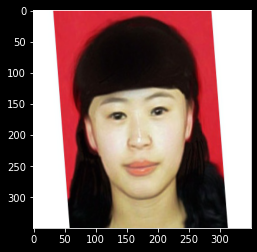

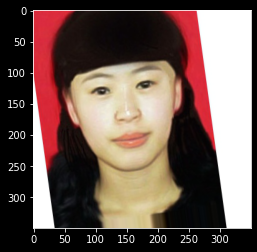

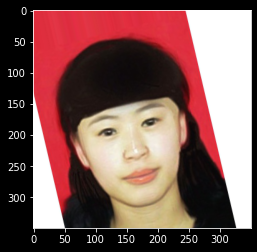

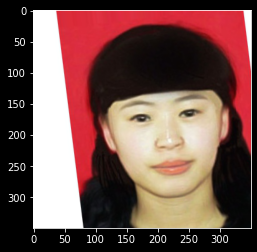

In [9]:
gen = ImageDataGenerator(rotation_range=15, width_shift_range=0.1,
                        height_shift_range=0.1, shear_range=0.15,
                        zoom_range = 0.1, channel_shift_range=10,
                        horizontal_flip = True)


#Generate batches of augumented images from this image
image_path = 'data/SCUT-FBP5500_v2/Images/AF1.jpg'
image = np.expand_dims(matplotlib.pyplot.imread(image_path),0)
aug_iter = gen.flow(image)

#Get 10 samples of augumented images
aug_images = [next(aug_iter)[0].astype(np.uint8) for i in range(10)]

for i in range(10):
    image_show = aug_images[i]
    plt.imshow(image_show)
    plt.show()

In [5]:
#Above is augumentation on single image, now doing it for complete dataset
def Data_Augumentor(image_path):
    image = np.expand_dims(matplotlib.pyplot.imread(image_path),0)
    aug_iter = gen.flow(image)
    aug_images = [next(aug_iter)[0].astype(np.uint8) for i in range(10)]
    return aug_images

In [34]:
def augment():
    my_file = Path("data/SCUT-FBP5500_v2/Augumented/")
    dir = 'data/SCUT-FBP5500_v2/Images/'
    if not my_file.is_dir():
        # dir doesn't exists
        dir = 'data/SCUT-FBP5500_v2/Images/'
        output_dir = "data/SCUT-FBP5500_v2/Augumented"
        if not os.path.exists(output_dir):
            os.mkdir(output_dir)

    for file in os.listdir(dir):
        outfolder = os.path.splitext(file)[0]
        extension = os.path.splitext(file)[1]
        if not Path(output_dir+os.sep+outfolder).is_dir():
                    os.mkdir(output_dir+os.sep+outfolder)
        try:
            augumented_images = Data_Augumentor(dir+file)
            for i in range(10):
                cv2.imwrite(output_dir+os.sep+outfolder+"/"+str(i)+".jpg",cv2.cvtColor(augumented_images[i], cv2.COLOR_RGB2BGR))
            #print ("Augmented", file)
        except IOError:
                print ("cannot save image for ", file)
return



Augmented CF121.jpg
Augmented AF1607.jpg
Augmented AF1161.jpg
Augmented CM712.jpg
Augmented AF597.jpg
Augmented CF647.jpg
Augmented AF583.jpg
Augmented CF653.jpg
Augmented AF1175.jpg
Augmented CM706.jpg
Augmented AF1613.jpg
Augmented CF135.jpg
Augmented AM398.jpg
Augmented AM1846.jpg
Augmented AF1149.jpg
Augmented AM1852.jpg
Augmented CF109.jpg
Augmented AF88.jpg
Augmented AF63.jpg
Augmented AM367.jpg
Augmented AF232.jpg
Augmented AM1661.jpg
Augmented AF554.jpg
Augmented AM1107.jpg
Augmented CF684.jpg
Augmented AM401.jpg
Augmented AM415.jpg
Augmented AF540.jpg
Augmented CF690.jpg
Augmented AM1113.jpg
Augmented AF226.jpg
Augmented AM1675.jpg
Augmented AF77.jpg
Augmented AF1808.jpg
Augmented AM373.jpg
Augmented AM1885.jpg
Augmented AF1820.jpg
Augmented AF568.jpg
Augmented AM429.jpg
Augmented AF1834.jpg
Augmented AM1649.jpg
Augmented AM1891.jpg
Augmented CF445.jpg
Augmented AF795.jpg
Augmented CM510.jpg
Augmented AF1363.jpg
Augmented AM818.jpg
Augmented AF1405.jpg
Augmented CM276.jpg
Augm

# Generating Features

### Abandoned first attempt
Euclidean distance and facial ratios might not be the best feature when facial positions and obstruction is not guaranteed. 

In [1]:
def attempt1():
	def facialRatio(points):
		x1 = points[0];
		y1 = points[1];
		x2 = points[2];
		y2 = points[3];
		x3 = points[4];
		y3 = points[5];
		x4 = points[6];
		y4 = points[7];

		dist1 = math.sqrt((x1-x2)**2 + (y1-y2)**2)
		dist2 = math.sqrt((x3-x4)**2 + (y3-y4)**2)

		ratio = dist1/dist2

		return ratio


	def generateFeatures(pointIndices1, pointIndices2, pointIndices3, pointIndices4, allLandmarkCoordinates):
		size = allLandmarkCoordinates.shape
		allFeatures = numpy.zeros((size[0], len(pointIndices1)))
		for x in range(0, size[0]):
			landmarkCoordinates = allLandmarkCoordinates[x, :]
			ratios = [];
			for i in range(0, len(pointIndices1)):
				x1 = landmarkCoordinates[2*(pointIndices1[i]-1)]
				y1 = landmarkCoordinates[2*pointIndices1[i] - 1]
				x2 = landmarkCoordinates[2*(pointIndices2[i]-1)]
				y2 = landmarkCoordinates[2*pointIndices2[i] - 1]

				x3 = landmarkCoordinates[2*(pointIndices3[i]-1)]
				y3 = landmarkCoordinates[2*pointIndices3[i] - 1]
				x4 = landmarkCoordinates[2*(pointIndices4[i]-1)]
				y4 = landmarkCoordinates[2*pointIndices4[i] - 1]

				points = [x1, y1, x2, y2, x3, y3, x4, y4]
				ratios.append(facialRatio(points))
			allFeatures[x, :] = numpy.asarray(ratios)
		return allFeatures


	def generateAllFeatures(allLandmarkCoordinates):
		a = [18, 22, 23, 27, 37, 40, 43, 46, 28, 32, 34, 36, 5, 9, 13, 49, 55, 52, 58]
		combinations = itertools.combinations(a, 4)
		i = 0
		pointIndices1 = [];
		pointIndices2 = [];
		pointIndices3 = [];
		pointIndices4 = [];

		for combination in combinations:
			pointIndices1.append(combination[0])
			pointIndices2.append(combination[1])
			pointIndices3.append(combination[2])
			pointIndices4.append(combination[3])
			i = i+1
			pointIndices1.append(combination[0])
			pointIndices2.append(combination[2])
			pointIndices3.append(combination[1])
			pointIndices4.append(combination[3])
			i = i+1
			pointIndices1.append(combination[0])
			pointIndices2.append(combination[3])
			pointIndices3.append(combination[1])
			pointIndices4.append(combination[2])
			i = i+1

		return generateFeatures(pointIndices1, pointIndices2, pointIndices3, pointIndices4, allLandmarkCoordinates)

	landmarks = numpy.loadtxt('../data/landmarks.txt', delimiter=',', usecols=range(136))

	featuresALL = generateAllFeatures(landmarks)
	numpy.savetxt('features_ALL.txt', featuresALL, delimiter=',', fmt = '%.04f')
 
 return

# Attempt 2 @ Feature Extraction

In [145]:
# skipped the above two methods for a filtering technique instead
def generate_features_df(filename, directory, df_orig, shape=True):
    """
    This function generates all the Supervised ML features we will use pixel by pixel.
    
    Dependency: 
    from skimage.filters import roberts, sobel, scharr, prewitt
    from scipy import ndimage as nd
    
    parmeters: 
    filename = e.g CM1.jpg
    directory = e.g 'data/'
    df_orig = pd.Dataframe()
    if shape then reshape to pixel form
    """
    df = pd.DataFrame()
    df['Filename'] = [filename]
    img = cv2.cvtColor(cv2.imread(directory+filename), cv2.COLOR_BGR2GRAY) 
    
    # Gender & Race encoding
    txt = os.path.splitext(f)[0]
    if txt[1] == 'M' :
        ml_df['male'] = 1
    if txt[0] == 'A':
        ml_df['asian'] = 1
    
    # Save original image pixels into a data frame. This is our Feature #1.
    ml_df['Orig_img'] = [img]
    img2 = img.reshape(-1)
    
    ### EDGE DETECTION ###
    
    # Generate Gabor features manually because sci-kit gabor() breaks machine
    num = 1  # To count numbers up in order to give Gabor features a label in the data frame
    kernels = []
    for theta in range(2):   # Define number of thetas
        theta = theta / 4. * np.pi
        for sigma in (1, 3):  # Sigma with 1 and 3
            for lamda in np.arange(0, np.pi, np.pi / 4):   # Range of wavelengths
                for gamma in (0.05, 0.5):   # Gamma values of 0.05 and 0.5
                
                    
                    gabor_label = 'Gabor' + str(num)  # Label Gabor columns as Gabor1, Gabor2, etc.
                    ksize=9
                    kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, 0, ktype=cv2.CV_32F)    
                    kernels.append(kernel)
                    
                    # Now filter the image and add values to a new column 
                    fimg = cv2.filter2D(img2, cv2.CV_8UC3, kernel)
                    if shape:
                        fimg = fimg.reshape(-1)
                        df[gabor_label] = fimg
                    df[gabor_label] = [fimg]  # Labels columns as Gabor1, Gabor2, etc.
                    # print(gabor_label, ': theta=', theta, ': sigma=', sigma, ': lamda=', lamda, ': gamma=', gamma)
                    num += 1  # Increment for gabor column label              
      
    # To visualize any of these filters use e.g imshow(edges_roberts, cmap='gray')            
    # CANNY EDGE
    edges = cv2.Canny(img, 100,200)   #Image, min and max values
    if shape:
        edges = edges.reshape(-1)
        df['Canny Edge'] = edges
    df['Canny Edge'] = [edges] #Add column to original dataframe

    # ROBERTS EDGE
    edge_roberts = roberts(img)
    if shape:
        edge_roberts = edge_roberts.reshape(-1)
        df['Roberts'] = edge_roberts
    df['Roberts'] = [edge_roberts]

    # SOBEL EDGE
    edge_sobel = sobel(img)
    if shape:
        edge_sobel = edge_sobel.reshape(-1)
        df['Sobel'] = edge_sobel
    df['Sobel'] = [edge_sobel]

    # SCHARR EDGE
    edge_scharr = scharr(img)
    if shape:
        edge_scharr = edge_scharr.reshape(-1)
        df['Scharr'] = edge_scharr
    df['Scharr'] = [edge_scharr]

    # PREWITT EDGE
    edge_prewitt = prewitt(img)
    if shape:
        edge_prewitt1= edge_prewitt.reshape(-1)
        df['Prewitt'] = edge_prewitt
    df['Prewitt'] = [edge_prewitt]

    # GAUSSIAN with sigma=3
    gaussian_img = nd.gaussian_filter(img, sigma=3)
    if shape:
        gaussian_img = gaussian_img.reshape(-1)
        df['Gaussian s3'] = gaussian_img
    df['Gaussian s3'] = [gaussian_img]

    # GAUSSIAN with sigma=7
    gaussian_img2 = nd.gaussian_filter(img, sigma=7)
    if shape:
        gaussian_img2 = gaussian_img2.reshape(-1)
        df['Gaussian s7'] = gaussian_img2
    df['Gaussian s7'] = [gaussian_img2]

    # MEDIAN with sigma=3
    median_img = nd.median_filter(img, size=3)
    if shape:
        median_img = median_img.reshape(-1)
        df['Median s3'] = median_img
    df['Median s3'] = [median_img]

    # VARIANCE with size=3
    variance_img = nd.generic_filter(img, np.var, size=3)
    if shape:
        variance_img = variance_img.reshape(-1)
        df['Variance s3'] = variance_img
    df['Variance s3'] = [variance_img]  #Add column to original dataframe
    
    return pd.concat([df_orig, df])
    

In [146]:
def feature_df_creation():
    d = 'data/SCUT-FBP5500_v2/Images/'
    test = pd.DataFrame()

    # now let's loop through files to create the dataframe features
    for f in os.listdir(d)[:1]:
        test = generate_features_df(f, d, test, shape=False)
return test

df = feature_df_creation()

(-0.5, 36.5, 36.5, -0.5)

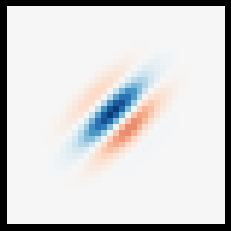

In [160]:
# explaining Gabor filters
# TLDR Gabor is the father of holography and it is a good filter that adds minimal spatial invariance 

g=gabor_kernel(frequency=0.1, theta=math.pi/4, 
               sigma_x=3.0, sigma_y=5.0, offset=math.pi/5, n_stds=5)
plt.imshow(np.real(g), cmap='RdBu', interpolation='none', 
           vmin=-abs(g).max(), vmax=abs(g).max())
plt.axis('off')

# Explaining Gabor Filters

In [4]:
# The code to create interactive plots
# This all breaks my hardware due to the Gabor filter in sci-kit-image, hence the manual method employed.

def plot_gabor_filtering(image, frequency, theta, response_fn=np.real, image_shift_x=0, image_shift_y=0):
    """Plots the results of the real part of the Gabor filter."""
    H, W = image.shape
    original=np.pad(image, ((image_shift_y,0), (image_shift_x,0)), mode='reflect')[:H,:W]
    fig, axs = plt.subplots(1, 4, figsize=(15,5))
    axs[0].imshow(original,cmap='gray',interpolation='none')
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    delta_image=np.zeros(original.shape, dtype=float)
    delta_image[np.array(delta_image.shape)//2]=1.0 # 1.0 at the center
    kernel_real, kernel_imag=gabor(delta_image, frequency=frequency, theta=theta)
    kernel=kernel_real + 1j*kernel_imag
    axs[1].imshow(response_fn(kernel),cmap='gray',interpolation='none')
    axs[1].set_title('Filter (%s)' % response_fn.__name__)
    axs[1].axis('off')
    
    response_real,response_imag=gabor(original, frequency=frequency, theta=theta)
    response=response_real + 1j*response_imag
    axs[2].imshow(response_fn(response),cmap='gray',interpolation='none')
    axs[2].set_title('Filter Response')
    axs[2].axis('off')
    
    unshifted_real,unshifted_imag=gabor(image, frequency=frequency, theta=theta)
    unshifted_response=unshifted_real + 1j*unshifted_imag
    difference=(response_fn(response)-response_fn(unshifted_response)) / response_fn(unshifted_response).std()
    axs[3].imshow(difference,cmap='gray',interpolation='none', vmin=-2, vmax=2)
    axs[3].set_title('Difference from unshifted (NRMSE=%f)' % sqrt((difference**2).mean()))
    axs[3].axis('off')

In [7]:
image = cv2.cvtColor(cv2.imread('data/SCUT-FBP5500_v2/Images/CM1.jpg'), cv2.COLOR_BGR2GRAY)
H, W = image.shape
original=np.pad(image, ((0,0), (0,0)), mode='reflect')[:H,:W]
delta_image=np.zeros(original.shape, dtype=float)

In [169]:
interactive(plot_gabor_filtering, 
            image=cv2.imread('data/SCUT-FBP5500_v2/Images/CM1.jpg'),
            frequency= FloatSlider(min=0.001, max=0.5, value=0.1),
            theta= FloatSlider(min=0, max=math.pi, value=math.pi / 2.0),
            response_fn={'Real': np.real, 'Imag': np.imag, 'Abs': np.abs},
            image_shift_x= IntSlider(min=0, max=10, value=0),
            image_shift_y= IntSlider(min=0, max=10, value=0))

TraitError: Invalid selection: value not found

# To Do
## Descriptive Charts To Make
1. score distribution of the 4 subsets
2. Standard deviation of the 4 subsets
3. boxplot of the four subsets
4. Score distribution of male, female, all labelers
5. Show a filter matrix for report
6. Use SVM , Random Forest, Linear Regression pipeline for ML
7. Report model performance from grid search using box plots
8. Compare to CNN using different architecture ( i.e image classification CNN versus KG CNN)
9. Consider recommendation output based on rater instead of aggregated.